<a href="https://colab.research.google.com/github/anannya-anu/7th-semester/blob/main/2125051105_7B2_Anannya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import shutil


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Path to your chess piece images
base_dir = '/content/drive/MyDrive/Machine Learning_code/Machine_learning_project/ML_project_dataset/vehicel-image/Dataset'
split_dir = '/content/drive/MyDrive/split_data'


In [6]:
def split_data(base_dir, split_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

    for split in ['train', 'val', 'test']:
        if not os.path.exists(os.path.join(split_dir, split)):
          os.makedirs(os.path.join(split_dir, split), exist_ok=True)

    for category in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category)
        if not os.path.isdir(category_path):
            continue

        # Collect all images recursively
        images = [os.path.join(root, img)
                  for root, _, files in os.walk(category_path)
                  for img in files if img.lower().endswith(('png', 'jpg', 'jpeg'))]

        print(f"Category: {category}, Total Images: {len(images)}")  # Debugging line

        if len(images) == 0:
            print(f"Skipping {category} as no images found.")
            continue

        train_images, temp_images = train_test_split(images, train_size=train_size, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=test_size/(val_size + test_size), random_state=42)

        for split, img_list in [('train', train_images), ('val', val_images), ('test', test_images)]:
            split_category_dir = os.path.join(split_dir, split, category)
            os.makedirs(split_category_dir, exist_ok=True)

            for img_path in img_list:
                shutil.copy(img_path, os.path.join(split_category_dir, os.path.basename(img_path)))

split_data(base_dir, split_dir)


Category: Truck, Total Images: 100
Category: Car, Total Images: 100
Category: Bus, Total Images: 100
Category: motorcycle, Total Images: 100


In [7]:
for split in ['train', 'val', 'test']:
    for category in os.listdir(os.path.join(split_dir, split)):
        num_images = len(os.listdir(os.path.join(split_dir, split, category)))
        print(f"{split.capitalize()} - {category}: {num_images} images")


Train - Truck: 70 images
Train - Car: 70 images
Train - Bus: 70 images
Train - motorcycle: 70 images
Val - Truck: 15 images
Val - Car: 15 images
Val - Bus: 15 images
Val - motorcycle: 15 images
Test - Truck: 15 images
Test - Car: 15 images
Test - Bus: 15 images
Test - motorcycle: 15 images


In [8]:
# Image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(split_dir, 'train'),  # Your training data directory
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation data generator
validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_dir, 'val'),  # Your validation data directory
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test data generator
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_dir, 'test'),  # Your test data directory
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important: Keep shuffle=False for test data
)

Found 280 images belonging to 4 classes.
Found 60 images belonging to 4 classes.
Found 60 images belonging to 4 classes.


In [15]:

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))  # Increased dropout to reduce overfitting

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))  # Increased dropout

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))  # Increased dropout

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # L2 regularization
model.add(Dropout(0.6))  # Increased dropout to further reduce overfitting
model.add(Dense(train_generator.num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,829,764 (18.42 MB)

 Trainable params: 4,829,316 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.2881 - loss: 7.7225

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.2861 - loss: 7.6887 - val_accuracy: 0.2500 - val_loss: 3.9368
Epoch 2/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2188 - loss: 6.6683

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.2188 - loss: 6.6683 - val_accuracy: 0.3214 - val_loss: 3.9340
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.2497 - loss: 5.5165
Epoch 4/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2812 - loss: 4.5631

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.2812 - loss: 4.5631 - val_accuracy: 0.3438 - val_loss: 4.0121
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.2515 - loss: 4.2479 - val_accuracy: 0.2143 - val_loss: 5.1492
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3438 - loss: 4.1505
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 533ms/step - accuracy: 0.2723 - loss: 3.9918 - val_accuracy: 0.3125 - val_loss: 5.2632
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.3750 - loss: 3.8496 - val_accuracy: 0.3214 - val_loss: 5.2821
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - accuracy: 0.3549 - loss: 3.9377
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.3125 - loss: 4.0058 - val_accuracy: 0.3125 - val_loss: 5.6408
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2000 - loss: 3.9649
Test Loss: 3.9301
Test Accuracy: 0.3000


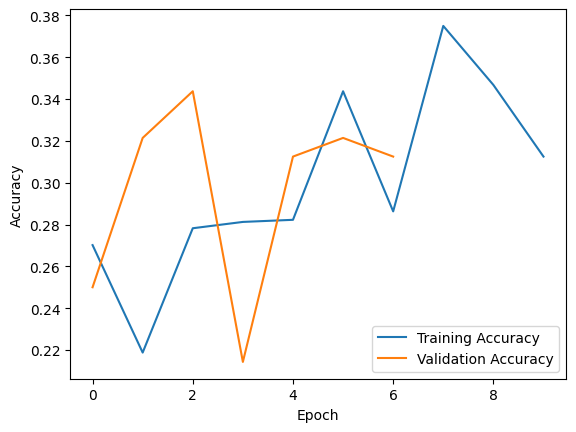

In [16]:

# Train the model
epochs = 50  # Increased epochs to allow for more training time
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [17]:
# prompt: print the classification report based on test ML_project_dataset

from sklearn.metrics import classification_report

# Get predictions for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test set
y_true = test_generator.classes

# Print the classification report
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
              precision    recall  f1-score   support

         Bus       0.00      0.00      0.00        15
         Car       0.00      0.00      0.00        15
       Truck       0.50      0.20      0.29        15
  motorcycle       0.28      1.00      0.43        15

    accuracy                           0.30        60
   macro avg       0.19      0.30      0.18        60
weighted avg       0.19      0.30      0.18        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
